# Import libraries

In [1]:
import torch
from torch import tensor
import argparse
import numpy as np
from torch_geometric.datasets import Planetoid, KarateClub
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Coauthor
from torch_geometric.datasets import CitationFull
from collections import namedtuple
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import os
import torchmetrics

2024-05-06 18:48:03.561687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 18:48:04.622474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64/stubs:/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64/stubs:/usr/local/cuda-11.0/lib64:
2024-05-06 18:48:04.622600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /

# Utils

In [2]:
#standard functions
import numpy as np
import pygsp as gsp

def to_networkx():
    import networkx as nx
    return nx.from_scipy_sparse_matrix(G.W)
    
def get_neighbors(G, i):
    return G.A[i,:].indices
    # return np.arange(G.N)[np.array((G.W[i,:] > 0).todense())[0]]
    
def get_giant_component(G):

    from scipy.sparse import csgraph

    [ncomp, labels] = csgraph.connected_components(G.W, directed=False, return_labels=True)

    W_g = np.array((0,0))
    coords_g = np.array((0,2))
    keep = np.array(0)
    
    for i in range(0,ncomp):
        
        idx = np.where(labels!=i)
        idx = idx[0]
        
        if G.N-len(idx) > W_g.shape[0]:        
            W_g = G.W.toarray()
            W_g = np.delete(W_g, idx, axis=0)
            W_g = np.delete(W_g, idx, axis=1)
            if hasattr(G, 'coords'):
                coords_g = np.delete(G.coords, idx, axis=0)
            keep = np.delete(np.arange(G.N), idx)    

    if not hasattr(G, 'coords'):
        # print(W_g.shape)
        G_g = gsp.graphs.Graph(W=W_g)        
    else:
        G_g = gsp.graphs.Graph(W=W_g, coords=coords_g)

    
    return (G_g, keep)


def get_S(G):
    """
    Construct the N x |E| gradient matrix S
    """
    # the edge set
    edges = G.get_edge_list()
    weights = np.array(edges[2])
    edges = np.array(edges[0:2])
    M = edges.shape[1]
    
    # Construct the N x |E| gradient matrix S
    S = np.zeros((G.N,M))
    for e in np.arange(M):
        S[edges[0,e], e] = np.sqrt(weights[e])
        S[edges[1,e], e] = -np.sqrt(weights[e])
        
    return S   

# Compare the spectum of L and Lc
def eig(A, order='ascend'):

    # eigenvalue decomposition
    [l,X] = np.linalg.eigh(A)

    # reordering indices     
    idx = l.argsort()   
    if order == 'descend':
        idx = idx[::-1]

    # reordering     
    l = np.real(l[idx])
    X = X[:, idx]
    return (X,np.real(l))

def zero_diag(A):
    
    import scipy as sp

    if sp.sparse.issparse(A):
        return A - sp.sparse.dia_matrix((A.diagonal()[sp.newaxis, :], [0]), shape=(A.shape[0], A.shape[1]))
    else:
        D = A.diagonal()
        return A - np.diag(D)

def is_symmetric(As):
    """Check if a sparse matrix is symmetric

    Parameters
    ----------
    As : array or sparse matrix
        A square matrix.

    Returns
    -------
    check : bool
        The check result.

    """
    from scipy import sparse 
    
    if As.shape[0] != As.shape[1]:
        return False

    if not isinstance(As, sparse.coo_matrix):
        As = sparse.coo_matrix(As)

    r, c, v = As.row, As.col, As.data
    tril_no_diag = r > c
    triu_no_diag = c > r

    if triu_no_diag.sum() != tril_no_diag.sum():
        return False

    rl = r[tril_no_diag]
    cl = c[tril_no_diag]
    vl = v[tril_no_diag]
    ru = r[triu_no_diag]
    cu = c[triu_no_diag]
    vu = v[triu_no_diag]

    sortl = np.lexsort((cl, rl))
    sortu = np.lexsort((ru, cu))
    vl = vl[sortl]
    vu = vu[sortu]

    check = np.allclose(vl, vu)

    return check


In [3]:
#coarsening related functions
import numpy as np
import pygsp as gsp
from pygsp import graphs, filters, reduction
import scipy as sp
from scipy import sparse

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

from sortedcontainers import SortedList
from GCN.graph_coarsening import maxWeightMatching


def coarsen(
    G,
    K=10,
    r=0.5,
    max_levels=10,
    method="variation_neighborhood",
    algorithm="greedy",
    Uk=None,
    lk=None,
    max_level_r=0.99,
):
    """
    This function provides a common interface for coarsening algorithms that contract subgraphs

    Parameters
    ----------
    G : pygsp Graph
    K : int
        The size of the subspace we are interested in preserving.
    r : float between (0,1)
        The desired reduction defined as 1 - n/N.
    method : String
        ['variation_neighborhoods', 'variation_edges', 'variation_cliques', 'heavy_edge', 'algebraic_JC', 'affinity_GS', 'kron'] 
    
    Returns
    -------
    C : np.array of size n x N
        The coarsening matrix.
    Gc : pygsp Graph
        The smaller graph.
    Call : list of np.arrays
        Coarsening matrices for each level
    Gall : list of (n_levels+1) pygsp Graphs
        All graphs involved in the multilevel coarsening

    Example
    -------
    C, Gc, Call, Gall = coarsen(G, K=10, r=0.8)
    """
    r = np.clip(r, 0, 0.999)
    G0 = G
    N = G.N

    # current and target graph sizes
    n, n_target = N, np.ceil((1 - r) * N)

    C = sp.sparse.eye(N, format="csc")
    Gc = G
    mapping_dict_list = []

    Call, Gall = [], []
    Gall.append(G)

    for level in range(1, max_levels + 1):

        G = Gc
        mapping_dict = {}
        # how much more we need to reduce the current graph
        r_cur = np.clip(1 - n_target / n, 0.0, max_level_r)

        if "variation" in method:

            if level == 1:
                if (Uk is not None) and (lk is not None) and (len(lk) >= K):
                    mask = lk < 1e-10
                    lk[mask] = 1
                    lsinv = lk ** (-0.5)
                    lsinv[mask] = 0
                    B = Uk[:, :K] @ np.diag(lsinv[:K])
                else:
                    offset = 2 * max(G.dw)
                    T = offset * sp.sparse.eye(G.N, format="csc") - G.L
                    lk, Uk = sp.sparse.linalg.eigsh(T.toarray(), k=K, which="LM", tol=1e-5)
                    lk = (offset - lk)[::-1]
                    Uk = Uk[:, ::-1]
                    mask = lk < 1e-10
                    lk[mask] = 1
                    lsinv = lk ** (-0.5)
                    lsinv[mask] = 0
                    B = Uk @ np.diag(lsinv)
                A = B
            else:
                B = iC.dot(B)
                d, V = np.linalg.eig(B.T @ (G.L).dot(B))
                mask = d == 0
                d[mask] = 1
                dinvsqrt = d ** (-1 / 2)
                dinvsqrt[mask] = 0
                A = B @ np.diag(dinvsqrt) @ V

            if method == "variation_edges":
                coarsening_list = contract_variation_edges(
                    G, K=K, A=A, r=r_cur, algorithm=algorithm
                )
            else:
                coarsening_list = contract_variation_linear(
                    G, K=K, A=A, r=r_cur, mode=method
                )

        else:
            weights = get_proximity_measure(G, method, K=K)

            if algorithm == "optimal":
                # the edge-weight should be light at proximal edges
                weights = -weights
                if "rss" not in method:
                    weights -= min(weights)
                coarsening_list = matching_optimal(G, weights=weights, r=r_cur)

            elif algorithm == "greedy":
                coarsening_list = matching_greedy(G, weights=weights, r=r_cur)
        iC = get_coarsening_matrix(G, coarsening_list)
        #print(coarsening_list, mapping_dict)
        
        if iC.shape[1] - iC.shape[0] <= 2:
            #print(coarsening_list)
            for i in range(G.N):
                mapping_dict[i] = i
            mapping_dict_list.append(mapping_dict)
            print("Warning: too many edges are being contracted")
            break  # avoid too many levels for so few nodes

        C = iC.dot(C)
        Call.append(iC)

        Wc = zero_diag(coarsen_matrix(G.W, iC))  # coarsen and remove self-loops
        Wc = (Wc + Wc.T) / 2  # this is only needed to avoid pygsp complaining for tiny errors

        if not hasattr(G, "coords"):
            Gc = gsp.graphs.Graph(Wc)
        else:
            Gc = gsp.graphs.Graph(Wc, coords=coarsen_vector(G.coords, iC))
        Gall.append(Gc)

        n = Gc.N
        new_num = 0
        in_list = False
        for i in range(N):
            for sublist in coarsening_list:
                if i in sublist:
                    if any(j in list(mapping_dict.keys()) for j in sublist):
                        common = np.intersect1d(sublist, list(mapping_dict.keys()))
                        mapping_dict[i] = mapping_dict[common[0]]
                        in_list = True
                        break
                    else:
                        mapping_dict[i] = new_num
                        new_num += 1
                        in_list = True
                        break
                else:
                    in_list = False
            if not in_list:
                mapping_dict[i] = new_num
                new_num += 1
        
        mapping_dict_list.append(mapping_dict)
        if n <= n_target:
            break

    return C, Gc, Call, Gall, mapping_dict_list


################################################################################
# General coarsening utility functions
################################################################################


def coarsen_vector(x, C):
    return (C.power(2)).dot(x)


def lift_vector(x, C):
    # Pinv = C.T; Pinv[Pinv>0] = 1
    D = sp.sparse.diags(np.array(1 / np.sum(C, 0))[0])
    Pinv = (C.dot(D)).T
    return Pinv.dot(x)


def coarsen_matrix(W, C):
    # Pinv = C.T; #Pinv[Pinv>0] = 1
    D = sp.sparse.diags(np.array(1 / np.sum(C, 0))[0])
    Pinv = (C.dot(D)).T
    return (Pinv.T).dot(W.dot(Pinv))


def lift_matrix(W, C):
    P = C.power(2)
    return (P.T).dot(W.dot(P))


def get_coarsening_matrix(G, partitioning):
    """
    This function should be called in order to build the coarsening matrix C.

    Parameters
    ----------
    G : the graph to be coarsened
    partitioning : a list of subgraphs to be contracted

    Returns
    -------
    C : the new coarsening matrix

    Example
    -------
    C = contract(gsp.graphs.sensor(20),[0,1]) ??
    """

    # C = np.eye(G.N)
    C = sp.sparse.eye(G.N, format="lil")

    rows_to_delete = []
    for subgraph in partitioning:

        nc = len(subgraph)

        # add v_j's to v_i's row
        C[subgraph[0], subgraph] = 1 / np.sqrt(nc)  # np.ones((1,nc))/np.sqrt(nc)

        rows_to_delete.extend(subgraph[1:])

    # delete vertices
    # C = np.delete(C,rows_to_delete,0)

    C.rows = np.delete(C.rows, rows_to_delete)
    C.data = np.delete(C.data, rows_to_delete)
    C._shape = (G.N - len(rows_to_delete), G.N)

    C = sp.sparse.csc_matrix(C)

    # check that this is a projection matrix
    # assert sp.sparse.linalg.norm( ((C.T).dot(C))**2 - ((C.T).dot(C)) , ord='fro') < 1e-5

    return C


def coarsening_quality(G, C, kmax=30, Uk=None, lk=None):
    """
    Measures how good is a coarsening.

    Parameters
    ----------
    G : pygsp Graph
    C : np.array(n,N)
        The coarsening matrix
    kmax : int
        Until which eigenvalue we are interested in.

    Returns
    -------
    metric : dictionary
        Contains all relevant metrics for coarsening quality:
        * error_eigenvalue : np.array(kmax)
        * error_subspace : np.array(kmax)
        * error_sintheta : np.array(kmax)
        * angle_matrix : np.array(kmax)
        * rss constants : np.array(kmax)
        as well as some general properties of Gc:
        * r : int
            reduction ratio
        * m : int
            number of edges
    """
    N = G.N
    I = np.eye(N)

    if (Uk is not None) and (lk is not None) and (len(lk) >= kmax):
        U, l = Uk, lk
    elif hasattr(G, "U"):
        U, l = G.U, G.e
    else:
        l, U = sp.sparse.linalg.eigsh(G.L, k=kmax, which="SM", tol=1e-3)

    l[0] = 1
    linv = l ** (-0.5)
    linv[0] = 0
    # l[0] = 0 # avoids divide by 0

    # below here, everything is C specific
    n = C.shape[0]
    Pi = C.T @ C
    S = get_S(G).T
    Lc = C.dot((G.L).dot(C.T))
    Lp = Pi @ G.L @ Pi

    if kmax > n / 2:
        [Uc, lc] = eig(Lc.toarray())
    else:
        lc, Uc = sp.sparse.linalg.eigsh(Lc, k=kmax, which="SM", tol=1e-3)

    if not sp.sparse.issparse(Lc):
        print("warning: Lc should be sparse.")

    metrics = {"r": 1 - n / N, "m": int((Lc.nnz - n) / 2)}

    kmax = np.clip(kmax, 1, n)

    # eigenvalue relative error
    metrics["error_eigenvalue"] = np.abs(l[:kmax] - lc[:kmax]) / l[:kmax]
    metrics["error_eigenvalue"][0] = 0

    # angles between eigenspaces
    metrics["angle_matrix"] = U.T @ C.T @ Uc

    # rss constants
    #    metrics['rss'] = np.diag(U.T @ Lp @ U)/l - 1
    #    metrics['rss'][0] = 0

    # other errors
    kmax = np.clip(kmax, 2, n)

    error_subspace = np.zeros(kmax)
    error_subspace_bound = np.zeros(kmax)
    error_sintheta = np.zeros(kmax)

    M = S @ Pi @ U @ np.diag(linv)
    #    M_bound = S @ (I - Pi) @ U @ np.diag(linv)

    for kIdx in range(1, kmax):
        error_subspace[kIdx] = np.abs(np.linalg.norm(M[:, : kIdx + 1], ord=2) - 1)
        #        error_subspace_bound[kIdx] = np.linalg.norm( M_bound[:,:kIdx + 1], ord=2)
        error_sintheta[kIdx] = (
            np.linalg.norm(metrics["angle_matrix"][0 : kIdx + 1, kIdx + 1 :], ord="fro")
            ** 2
        )

    metrics["error_subspace"] = error_subspace
    # metrics['error_subspace_bound'] = error_subspace_bound
    metrics["error_sintheta"] = error_sintheta

    return metrics


def plot_coarsening(
    Gall, Call, size=3, edge_width=0.8, node_size=20, alpha=0.55, title=""
):
    """
    Plot a (hierarchical) coarsening

    Parameters
    ----------
    G_all : list of pygsp Graphs
    Call  : list of np.arrays

    Returns
    -------
    fig : matplotlib figure
    """
    # colors signify the size of a coarsened subgraph ('k' is 1, 'g' is 2, 'b' is 3, and so on)
    colors = ["k", "g", "b", "r", "y"]

    n_levels = len(Gall) - 1
    if n_levels == 0:
        return None
    fig = plt.figure(figsize=(n_levels * size * 3, size * 2))

    for level in range(n_levels):

        G = Gall[level]
        edges = np.array(G.get_edge_list()[0:2])

        Gc = Gall[level + 1]
        #         Lc = C.dot(G.L.dot(C.T))
        #         Wc = sp.sparse.diags(Lc.diagonal(), 0) - Lc;
        #         Wc = (Wc + Wc.T) / 2
        #         Gc = gsp.graphs.Graph(Wc, coords=(C.power(2)).dot(G.coords))
        edges_c = np.array(Gc.get_edge_list()[0:2])
        C = Call[level]
        C = C.toarray()

        if G.coords.shape[1] == 2:
            ax = fig.add_subplot(1, n_levels + 1, level + 1)
            ax.axis("off")
            ax.set_title(f"{title} | level = {level}, N = {G.N}")

            [x, y] = G.coords.T
            for eIdx in range(0, edges.shape[1]):
                ax.plot(
                    x[edges[:, eIdx]],
                    y[edges[:, eIdx]],
                    color="k",
                    alpha=alpha,
                    lineWidth=edge_width,
                )
            for i in range(Gc.N):
                subgraph = np.arange(G.N)[C[i, :] > 0]
                ax.scatter(
                    x[subgraph],
                    y[subgraph],
                    c=colors[np.clip(len(subgraph) - 1, 0, 4)],
                    s=node_size * len(subgraph),
                    alpha=alpha,
                )

        elif G.coords.shape[1] == 3:
            ax = fig.add_subplot(1, n_levels + 1, level + 1, projection="3d")
            ax.axis("off")

            [x, y, z] = G.coords.T
            for eIdx in range(0, edges.shape[1]):
                ax.plot(
                    x[edges[:, eIdx]],
                    y[edges[:, eIdx]],
                    zs=z[edges[:, eIdx]],
                    color="k",
                    alpha=alpha,
                    lineWidth=edge_width,
                )
            for i in range(Gc.N):
                subgraph = np.arange(G.N)[C[i, :] > 0]
                ax.scatter(
                    x[subgraph],
                    y[subgraph],
                    z[subgraph],
                    c=colors[np.clip(len(subgraph) - 1, 0, 4)],
                    s=node_size * len(subgraph),
                    alpha=alpha,
                )

    # the final graph
    Gc = Gall[-1]
    edges_c = np.array(Gc.get_edge_list()[0:2])

    if G.coords.shape[1] == 2:
        ax = fig.add_subplot(1, n_levels + 1, n_levels + 1)
        ax.axis("off")
        [x, y] = Gc.coords.T
        ax.scatter(x, y, c="k", s=node_size, alpha=alpha)
        for eIdx in range(0, edges_c.shape[1]):
            ax.plot(
                x[edges_c[:, eIdx]],
                y[edges_c[:, eIdx]],
                color="k",
                alpha=alpha,
                lineWidth=edge_width,
            )

    elif G.coords.shape[1] == 3:
        ax = fig.add_subplot(1, n_levels + 1, n_levels + 1, projection="3d")
        ax.axis("off")
        [x, y, z] = Gc.coords.T
        ax.scatter(x, y, z, c="k", s=node_size, alpha=alpha)
        for eIdx in range(0, edges_c.shape[1]):
            ax.plot(
                x[edges_c[:, eIdx]],
                y[edges_c[:, eIdx]],
                z[edges_c[:, eIdx]],
                color="k",
                alpha=alpha,
                lineWidth=edge_width,
            )

    ax.set_title(f"{title} | level = {n_levels}, n = {Gc.N}")
    fig.tight_layout()
    return fig


################################################################################
# Variation-based contraction algorithms
################################################################################


def contract_variation_edges(G, A=None, K=10, r=0.5, algorithm="greedy"):
    """
    Sequential contraction with local variation and edge-based families.
    This is a specialized implementation for the edge-based family, that works
    slightly faster than the contract_variation() function, which works for
    any family.

    See contract_variation() for documentation.
    """
    N, deg, M = G.N, G.dw, G.Ne
    ones = np.ones(2)
    Pibot = np.eye(2) - np.outer(ones, ones) / 2

    # cost function for the edge
    def subgraph_cost(G, A, edge):
        edge, w = edge[:2].astype(np.int), edge[2]
        deg_new = 2 * deg[edge] - w
        L = np.array([[deg_new[0], -w], [-w, deg_new[1]]])
        B = Pibot @ A[edge, :]
        return np.linalg.norm(B.T @ L @ B)

    # cost function for the edge
    def subgraph_cost_old(G, A, edge):
        w = G.W[edge[0], edge[1]]
        deg_new = 2 * deg[edge] - w
        L = np.array([[deg_new[0], -w], [-w, deg_new[1]]])
        B = Pibot @ A[edge, :]
        return np.linalg.norm(B.T @ L @ B)

    # edges = np.array(G.get_edge_list()[0:2])
    edges = np.array(G.get_edge_list())
    weights = np.array([subgraph_cost(G, A, edges[:, e]) for e in range(M)])
    # weights = np.zeros(M)
    # for e in range(M):
    #    weights[e] = subgraph_cost_old(G, A, edges[:,e])

    if algorithm == "optimal":
        # identify the minimum weight matching
        coarsening_list = matching_optimal(G, weights=weights, r=r)

    elif algorithm == "greedy":
        # find a heavy weight matching
        coarsening_list = matching_greedy(G, weights=-weights, r=r)

    return coarsening_list


def contract_variation_linear(G, A=None, K=10, r=0.5, mode="neighborhood"):
    """
    Sequential contraction with local variation and general families.
    This is an implemmentation that improves running speed,
    at the expense of being more greedy (and thus having slightly larger error).

    See contract_variation() for documentation.
    """

    N, deg, W_lil = G.N, G.dw, G.W.tolil()

    # The following is correct only for a single level of coarsening.
    # Normally, A should be passed as an argument.
    if A is None:
        lk, Uk = sp.sparse.linalg.eigsh(
            G.L, k=K, which="SM", tol=1e-3
        )  # this is not optimized!
        lk[0] = 1
        lsinv = lk ** (-0.5)
        lsinv[0] = 0
        lk[0] = 0
        D_lsinv = np.diag(lsinv)
        A = Uk @ np.diag(lsinv)

    # cost function for the subgraph induced by nodes array
    def subgraph_cost(nodes):
        nc = len(nodes)
        ones = np.ones(nc)
        W = W_lil[nodes, :][:, nodes]  # .tocsc()
        L = np.diag(2 * deg[nodes] - W.dot(ones)) - W
        B = (np.eye(nc) - np.outer(ones, ones) / nc) @ A[nodes, :]
        return np.linalg.norm(B.T @ L @ B) / (nc - 1)

    class CandidateSet:
        def __init__(self, candidate_list):
            self.set = candidate_list
            self.cost = subgraph_cost(candidate_list)

        def __lt__(self, other):
            return self.cost < other.cost

    family = []
    W_bool = G.A + sp.sparse.eye(G.N, dtype=bool, format="csr")
    if "neighborhood" in mode:
        for i in range(N):
            # i_set = G.A[i,:].indices # graph_utils.get_neighbors(G, i)
            # i_set = np.append(i_set, i)
            i_set = W_bool[i, :].indices
            family.append(CandidateSet(i_set))

    if "cliques" in mode:
        import networkx as nx

        Gnx = nx.from_scipy_sparse_matrix(G.W)
        for clique in nx.find_cliques(Gnx):
            family.append(CandidateSet(np.array(clique)))

    else:
        if "edges" in mode:
            edges = np.array(G.get_edge_list()[0:2])
            for e in range(0, edges.shape[1]):
                family.append(CandidateSet(edges[:, e]))
        if "triangles" in mode:
            triangles = set([])
            edges = np.array(G.get_edge_list()[0:2])
            for e in range(0, edges.shape[1]):
                [u, v] = edges[:, e]
                for w in range(G.N):
                    if G.W[u, w] > 0 and G.W[v, w] > 0:
                        triangles.add(frozenset([u, v, w]))
            triangles = list(map(lambda x: np.array(list(x)), triangles))
            for triangle in triangles:
                family.append(CandidateSet(triangle))

    family = SortedList(family)
    marked = np.zeros(G.N, dtype=bool)

    # ----------------------------------------------------------------------------
    # Construct a (minimum weight) independent set.
    # ----------------------------------------------------------------------------
    coarsening_list = []
    # n, n_target = N, (1-r)*N
    n_reduce = np.floor(r * N)  # how many nodes do we need to reduce/eliminate?

    while len(family) > 0:

        i_cset = family.pop(index=0)
        i_set = i_cset.set

        # check if marked
        i_marked = marked[i_set]

        if not any(i_marked):

            n_gain = len(i_set) - 1
            if n_gain > n_reduce:
                continue  # this helps avoid over-reducing

            # all vertices are unmarked: add i_set to the coarsening list
            marked[i_set] = True
            coarsening_list.append(i_set)
            # n -= len(i_set) - 1
            n_reduce -= n_gain

            # if n <= n_target: break
            if n_reduce <= 0:
                break

        # may be worth to keep this set
        else:
            i_set = i_set[~i_marked]
            if len(i_set) > 1:
                # todo1: check whether to add to coarsening_list before adding to family
                # todo2: currently this will also select contraction sets that are disconnected
                # should we eliminate those?
                i_cset.set = i_set
                i_cset.cost = subgraph_cost(i_set)
                family.add(i_cset)

    return coarsening_list


################################################################################
# Edge-based contraction algorithms
################################################################################


def get_proximity_measure(G, name, K=10):

    N = G.N
    W = G.W  # np.array(G.W.toarray(), dtype=np.float32)
    deg = G.dw  # np.sum(W, axis=0)
    edges = np.array(G.get_edge_list()[0:2])
    weights = np.array(G.get_edge_list()[2])
    M = edges.shape[1]

    num_vectors = K  # int(1*K*np.log(K))
    if "lanczos" in name:
        l_lan, X_lan = sp.sparse.linalg.eigsh(G.L, k=K, which="SM", tol=1e-2)
    elif "cheby" in name:
        X_cheby = generate_test_vectors(
            G, num_vectors=num_vectors, method="Chebychev", lambda_cut=G.e[K + 1]
        )
    elif "JC" in name:
        X_jc = generate_test_vectors(
            G, num_vectors=num_vectors, method="JC", iterations=20
        )
    elif "GS" in name:
        X_gs = generate_test_vectors(
            G, num_vectors=num_vectors, method="GS", iterations=1
        )
    if "expected" in name:
        X = X_lan
        assert not np.isnan(X).any()
        assert X.shape[0] == N
        K = X.shape[1]

    proximity = np.zeros(M, dtype=np.float32)

    # heuristic for mutligrid
    if name == "heavy_edge":
        wmax = np.array(np.max(G.W, 0).todense())[0] + 1e-5
        for e in range(0, M):
            proximity[e] = weights[e] / max(
                wmax[edges[:, e]]
            )  # select edges with large proximity
        return proximity

    # heuristic for mutligrid
    elif name == "algebraic_JC":
        proximity += np.Inf
        for e in range(0, M):
            i, j = edges[:, e]
            for kIdx in range(num_vectors):
                xk = X_jc[:, kIdx]
                proximity[e] = min(
                    proximity[e], 1 / max(np.abs(xk[i] - xk[j]) ** 2, 1e-6)
                )  # select edges with large proximity

        return proximity

    # heuristic for mutligrid
    elif name == "affinity_GS":
        c = np.zeros((N, N))
        for e in range(0, M):
            i, j = edges[:, e]
            c[i, j] = (X_gs[i, :] @ X_gs[j, :].T) ** 2 / (
                (X_gs[i, :] @ X_gs[i, :].T) ** 2 * (X_gs[j, :] @ X_gs[j, :].T) ** 2
            )  # select

        c += c.T
        c -= np.diag(np.diag(c))
        for e in range(0, M):
            i, j = edges[:, e]
            proximity[e] = c[i, j] / (max(c[i, :]) * max(c[j, :]))

        return proximity

    for e in range(0, M):
        i, j = edges[:, e]

        if name == "heavy_edge_degree":
            proximity[e] = (
                deg[i] + deg[j] + 2 * G.W[i, j]
            )  # select edges with large proximity

        # loose as little information as possible (custom)
        elif "min_expected_loss" in name:
            for kIdx in range(1, K):
                xk = X[:, kIdx]
                proximity[e] = sum(
                    [proximity[e], (xk[i] - xk[j]) ** 2]
                )  # select edges with small proximity
        # loose as little gradient information as possible (custom)
        elif name == "min_expected_gradient_loss":
            for kIdx in range(1, K):
                xk = X[:, kIdx]
                proximity[e] = sum(
                    [
                        proximity[e],
                        (xk[i] - xk[j]) ** 2 * (deg[i] + deg[j] + 2 * G.W[i, j]),
                    ]
                )  # select edges with small proximity

        # relaxation ensuring that K first eigenspaces are aligned (custom)
        elif name == "rss":
            for kIdx in range(1, K):
                xk = G.U[:, kIdx]
                lk = G.e[kIdx]
                proximity[e] = sum(
                    [
                        proximity[e],
                        (xk[i] - xk[j]) ** 2
                        * ((deg[i] + deg[j] + 2 * G.W[i, j]) / 4)
                        / lk,
                    ]
                )  # select edges with small proximity

        # fast relaxation ensuring that K first eigenspaces are aligned (custom)
        elif name == "rss_lanczos":
            for kIdx in range(1, K):
                xk = X_lan[:, kIdx]
                lk = l_lan[kIdx]
                proximity[e] = sum(
                    [
                        proximity[e],
                        (xk[i] - xk[j]) ** 2
                        * ((deg[i] + deg[j] + 2 * G.W[i, j]) / 4 - 0.5 * (lk + lk))
                        / lk,
                    ]
                )  # select edges with small proximity

        # approximate relaxation ensuring that K first eigenspaces are aligned (custom)
        elif name == "rss_cheby":
            for kIdx in range(num_vectors):
                xk = X_cheby[:, kIdx]
                lk = xk.T @ G.L @ xk
                proximity[e] = sum(
                    [
                        proximity[e],
                        (
                            (xk[i] - xk[j]) ** 2
                            * ((deg[i] + deg[j] + 2 * G.W[i, j]) / 4 - 0 * lk)
                            / lk
                        ),
                    ]
                )  # select edges with small proximity

        # heuristic for mutligrid (algebraic multigrid)
        elif name == "algebraic_GS":
            proximity[e] = np.Inf
            for kIdx in range(num_vectors):
                xk = X_gs[:, kIdx]
                proximity[e] = min(
                    proximity[e], 1 / max(np.abs(xk[i] - xk[j]) ** 2, 1e-6)
                )  # select edges with large proximity

    if ("rss" in name) or ("expected" in name):
        proximity = -proximity

    return proximity


def generate_test_vectors(
    G, num_vectors=10, method="Gauss-Seidel", iterations=5, lambda_cut=0.1
):

    L = G.L
    N = G.N
    X = np.random.randn(N, num_vectors) / np.sqrt(N)

    if method == "GS" or method == "Gauss-Seidel":

        L_upper = sp.sparse.triu(L, 1, format="csc")
        L_lower_diag = sp.sparse.triu(L, 0, format="csc").T

        for j in range(num_vectors):
            x = X[:, j]
            for t in range(iterations):
                x = -sp.sparse.linalg.spsolve_triangular(L_lower_diag, L_upper @ x)
            X[:, j] = x
        return X

    if method == "JC" or method == "Jacobi":

        deg = G.dw.astype(np.float)
        D = sp.sparse.diags(deg, 0)
        deginv = deg ** (-1)
        deginv[deginv == np.Inf] = 0
        Dinv = sp.sparse.diags(deginv, 0)
        M = Dinv.dot(D - L)

        for j in range(num_vectors):
            x = X[:, j]
            for t in range(iterations):
                x = 0.5 * x + 0.5 * M.dot(x)
            X[:, j] = x
        return X

    elif method == "Chebychev":
        from pygsp import filters

        f = filters.Filter(G, lambda x: ((x <= lambda_cut) * 1).astype(np.float32))
        return f.filter(X, method="chebyshev", order=50)


def matching_optimal(G, weights, r=0.4):
    """
    Generates a matching optimally with the objective of minimizing the total
    weight of all edges in the matching.

    Parameters
    ----------
    G : pygsp graph
    weights : np.array(M)
        a weight for each edge
    ratio : float
        The desired dimensionality reduction (ratio = 1 - n/N)

    Notes:
    * The complexity of this is O(N^3)
    * Depending on G, the algorithm might fail to return ratios>0.3
    """
    N = G.N

    # the edge set
    edges = G.get_edge_list()
    edges = np.array(edges[0:2])
    M = edges.shape[1]

    max_weight = 1 * np.max(weights)

    # prepare the input for the minimum weight matching problem
    edge_list = []
    for edgeIdx in range(M):
        [i, j] = edges[:, edgeIdx]
        if i == j:
            continue
        edge_list.append((i, j, max_weight - weights[edgeIdx]))

    assert min(weights) >= 0

    # solve it
    tmp = np.array(maxWeightMatching.maxWeightMatching(edge_list))

    # format output
    m = tmp.shape[0]
    matching = np.zeros((m, 2), dtype=int)
    matching[:, 0] = range(m)
    matching[:, 1] = tmp

    # remove null edges and duplicates
    idx = np.where(tmp != -1)[0]
    matching = matching[idx, :]
    idx = np.where(matching[:, 0] > matching[:, 1])[0]
    matching = matching[idx, :]

    assert matching.shape[0] >= 1

    # if the returned matching is larger than what is requested, select the min weight subset of it
    matched_weights = np.zeros(matching.shape[0])
    for mIdx in range(matching.shape[0]):
        i = matching[mIdx, 0]
        j = matching[mIdx, 1]
        eIdx = [
            e
            for e, t in enumerate(edges[:, :].T)
            if ((t == [i, j]).all() or (t == [j, i]).all())
        ]
        matched_weights[mIdx] = weights[eIdx]

    keep = min(int(np.ceil(r * N)), matching.shape[0])
    if keep < matching.shape[0]:
        idx = np.argpartition(matched_weights, keep)
        idx = idx[0:keep]
        matching = matching[idx, :]

    return matching


def matching_greedy(G, weights, r=0.4):
    """
    Generates a matching greedily by selecting at each iteration the edge
    with the largest weight and then removing all adjacent edges from the
    candidate set.

    Parameters
    ----------
    G : pygsp graph
    weights : np.array(M)
        a weight for each edge
    r : float
        The desired dimensionality reduction (r = 1 - n/N)

    Notes:
    * The complexity of this is O(M)
    * Depending on G, the algorithm might fail to return ratios>0.3
    """

    N = G.N

    # the edge set
    edges = np.array(G.get_edge_list()[0:2])
    M = edges.shape[1]

    idx = np.argsort(-weights)
    # idx = np.argsort(weights)[::-1]
    edges = edges[:, idx]

    # the candidate edge set
    candidate_edges = edges.T.tolist()

    # the matching edge set (this is a list of arrays)
    matching = []

    # which vertices have been selected
    marked = np.zeros(N, dtype=bool)

    n, n_target = N, (1 - r) * N
    while len(candidate_edges) > 0:

        # pop a candidate edge
        [i, j] = candidate_edges.pop(0)

        # check if marked
        if any(marked[[i, j]]):
            continue

        marked[[i, j]] = True
        n -= 1

        # add it to the matching
        matching.append(np.array([i, j]))

        # termination condition
        if n <= n_target:
            break

    return np.array(matching)


##############################################################################
# Sparsification and Kron reduction
# Most of the code has been adapted from the PyGSP implementation.
##############################################################################
def kron_coarsening(G, r=0.5, m=None):

    if not hasattr(G, "coords"):
        G.set_coordinates(np.random.rand(G.N, 2))  # needed by kron

    n_target = np.floor((1 - r) * G.N)
    levels = int(np.ceil(np.log2(G.N / n_target)))

    try:
        Gs = my_graph_multiresolution(
            G,
            levels,
            r=r,
            sparsify=False,
            sparsify_eps=None,
            reduction_method="kron",
            reg_eps=0.01,
        )
        Gk = Gs[-1]

        # sparsify to a target number of edges m
        if m is not None:
            M = Gk.Ne  # int(Gk.W.nnz/2)
            epsilon = min(10 / np.sqrt(G.N), 0.3)  # 1 - m/M
            Gc = graph_sparsify(Gk, epsilon, maxiter=10)
            Gc.mr = Gk.mr
        else:
            Gc = Gk

        return Gc, Gs[0]

    except:
        return None, None


def kron_quality(G, Gc, kmax=30, Uk=None, lk=None):

    N, n = G.N, Gc.N
    keep_inds = Gc.mr["idx"]

    metrics = {"r": 1 - n / N, "m": int(Gc.W.nnz / 2), "failed": False}
    kmax = np.clip(kmax, 1, n)

    if (Uk is not None) and (lk is not None) and (len(lk) >= kmax):
        U, l = Uk, lk
    elif hasattr(G, "U"):
        U, l = G.U, G.e
    else:
        l, U = sp.sparse.linalg.eigsh(G.L, k=kmax, which="SM", tol=1e-3)

    l[0] = 1
    linv = l ** (-0.5)
    linv[0] = 0
    # avoids divide by 0

    C = np.eye(N)
    C = C[keep_inds, :]
    L = G.L.toarray()

    try:
        Phi = np.linalg.pinv(L + 0.01 * np.eye(N))
        Cinv = (Phi @ C.T) @ np.linalg.pinv(C @ Phi @ C.T)

        if kmax > n / 2:
            [Uc, lc] = eig(Gc.L.toarray())
        else:
            lc, Uc = sp.sparse.linalg.eigsh(Gc.L, k=kmax, which="SM", tol=1e-3)

        # eigenvalue relative error
        metrics["error_eigenvalue"] = np.abs(l[:kmax] - lc[:kmax]) / l[:kmax]
        metrics["error_eigenvalue"][0] = 0

        # TODO : angles between eigenspaces
        # metrics['angle_matrix'] = U.T @ C.T @ Uc

        # other errors
        kmax = np.clip(kmax, 2, n)

        error_subspace = np.zeros(kmax)
        error_sintheta = np.zeros(kmax)

        # M = (Lsqrtm - sp.linalg.sqrtm(Cinv @ Gc.L.dot(C))) @ U @ np.diag(linv) # is this correct?
        M = U - sp.linalg.sqrtm(Cinv @ Gc.L.dot(C)) @ U @ np.diag(
            linv
        )  # is this correct?
        for kIdx in range(0, kmax):
            error_subspace[kIdx] = np.abs(np.linalg.norm(M[:, : kIdx + 1], ord=2) - 1)

        metrics["error_subspace"] = error_subspace
        metrics["error_sintheta"] = error_sintheta

    except:
        metrics["failed"] = True

    return metrics


def kron_interpolate(G, Gc, x):
    return np.squeeze(reduction.interpolate(G, x, Gc.mr["idx"]))


def my_graph_multiresolution(
    G,
    levels,
    r=0.5,
    sparsify=True,
    sparsify_eps=None,
    downsampling_method="largest_eigenvector",
    reduction_method="kron",
    compute_full_eigen=False,
    reg_eps=0.005,
):
    r"""Compute a pyramid of graphs (by Kron reduction).

    'graph_multiresolution(G,levels)' computes a multiresolution of
    graph by repeatedly downsampling and performing graph reduction. The
    default downsampling method is the largest eigenvector method based on
    the polarity of the components of the eigenvector associated with the
    largest graph Laplacian eigenvalue. The default graph reduction method
    is Kron reduction followed by a graph sparsification step.
    *param* is a structure of optional parameters.

    Parameters
    ----------
    G : Graph structure
        The graph to reduce.
    levels : int
        Number of level of decomposition
    lambd : float
        Stability parameter. It adds self loop to the graph to give the
        algorithm some stability (default = 0.025). [UNUSED?!]
    sparsify : bool
        To perform a spectral sparsification step immediately after
        the graph reduction (default is True).
    sparsify_eps : float
        Parameter epsilon used in the spectral sparsification
        (default is min(10/sqrt(G.N),.3)).
    downsampling_method: string
        The graph downsampling method (default is 'largest_eigenvector').
    reduction_method : string
        The graph reduction method (default is 'kron')
    compute_full_eigen : bool
        To also compute the graph Laplacian eigenvalues and eigenvectors
        for every graph in the multiresolution sequence (default is False).
    reg_eps : float
        The regularized graph Laplacian is :math:`\bar{L}=L+\epsilon I`.
        A smaller epsilon may lead to better regularization, but will also
        require a higher order Chebyshev approximation. (default is 0.005)

    Returns
    -------
    Gs : list
        A list of graph layers.

    Examples
    --------
    >>> from pygsp import reduction
    >>> levels = 5
    >>> G = graphs.Sensor(N=512)
    >>> G.compute_fourier_basis()
    >>> Gs = reduction.graph_multiresolution(G, levels, sparsify=False)
    >>> for idx in range(levels):
    ...     Gs[idx].plotting['plot_name'] = 'Reduction level: {}'.format(idx)
    ...     Gs[idx].plot()

    """
    if sparsify_eps is None:
        sparsify_eps = min(10.0 / np.sqrt(G.N), 0.3)

    if compute_full_eigen:
        G.compute_fourier_basis()
    else:
        G.estimate_lmax()

    Gs = [G]
    Gs[0].mr = {"idx": np.arange(G.N), "orig_idx": np.arange(G.N)}

    n_target = int(np.floor(G.N * (1 - r)))

    for i in range(levels):
        if downsampling_method == "largest_eigenvector":
            if hasattr(Gs[i], "_U"):
                V = Gs[i].U[:, -1]
            else:
                V = sp.sparse.linalg.eigs(Gs[i].L, 1)[1][:, 0]

            V *= np.sign(V[0])
            n = max(int(Gs[i].N / 2), n_target)

            ind = np.argsort(V)  # np.nonzero(V >= 0)[0]
            ind = np.flip(ind, 0)
            ind = ind[:n]

        else:
            raise NotImplementedError("Unknown graph downsampling method.")

        if reduction_method == "kron":
            Gs.append(reduction.kron_reduction(Gs[i], ind))

        else:
            raise NotImplementedError("Unknown graph reduction method.")

        if sparsify and Gs[i + 1].N > 2:
            Gs[i + 1] = reduction.graph_sparsify(
                Gs[i + 1], min(max(sparsify_eps, 2.0 / np.sqrt(Gs[i + 1].N)), 1.0)
            )

        if Gs[i + 1].is_directed():
            W = (Gs[i + 1].W + Gs[i + 1].W.T) / 2
            Gs[i + 1] = graphs.Graph(W, coords=Gs[i + 1].coords)

        if compute_full_eigen:
            Gs[i + 1].compute_fourier_basis()
        else:
            Gs[i + 1].estimate_lmax()

        Gs[i + 1].mr = {"idx": ind, "orig_idx": Gs[i].mr["orig_idx"][ind], "level": i}

        L_reg = Gs[i].L + reg_eps * sparse.eye(Gs[i].N)
        Gs[i].mr["K_reg"] = reduction.kron_reduction(L_reg, ind)
        Gs[i].mr["green_kernel"] = filters.Filter(Gs[i], lambda x: 1.0 / (reg_eps + x))

    return Gs


def graph_sparsify(M, epsilon, maxiter=10):

    from pygsp import utils
    from scipy import sparse, stats

    # Test the input parameters
    if isinstance(M, graphs.Graph):
        if not M.lap_type == "combinatorial":
            raise NotImplementedError
        L = M.L
    else:
        L = M

    N = np.shape(L)[0]

    if not 1.0 / np.sqrt(N) <= epsilon < 1:
        raise ValueError("GRAPH_SPARSIFY: Epsilon out of required range")

    # Not sparse
    resistance_distances = utils.resistance_distance(L).toarray()
    # Get the Weight matrix
    if isinstance(M, graphs.Graph):
        W = M.W
    else:
        W = np.diag(L.diagonal()) - L.toarray()
        W[W < 1e-10] = 0

    W = sparse.coo_matrix(W)
    W.data[W.data < 1e-10] = 0
    W = W.tocsc()
    W.eliminate_zeros()

    start_nodes, end_nodes, weights = sparse.find(sparse.tril(W))

    # Calculate the new weights.
    weights = np.maximum(0, weights)
    Re = np.maximum(0, resistance_distances[start_nodes, end_nodes])
    Pe = weights * Re + 1e-4
    Pe = Pe / np.sum(Pe)

    for i in range(maxiter):
        # Rudelson, 1996 Random Vectors in the Isotropic Position
        # (too hard to figure out actual C0)
        C0 = 1 / 30.0
        # Rudelson and Vershynin, 2007, Thm. 3.1
        C = 4 * C0
        q = round(N * np.log(N) * 9 * C ** 2 / (epsilon ** 2))

        results = stats.rv_discrete(values=(np.arange(np.shape(Pe)[0]), Pe)).rvs(
            size=int(q)
        )
        spin_counts = stats.itemfreq(results).astype(int)
        per_spin_weights = weights / (q * Pe)

        counts = np.zeros(np.shape(weights)[0])
        counts[spin_counts[:, 0]] = spin_counts[:, 1]
        new_weights = counts * per_spin_weights

        sparserW = sparse.csc_matrix(
            (new_weights, (start_nodes, end_nodes)), shape=(N, N)
        )
        sparserW = sparserW + sparserW.T
        sparserL = sparse.diags(sparserW.diagonal(), 0) - sparserW

    #        if graphs.Graph(W=sparserW).is_connected():
    #            break
    #        elif i == maxiter - 1:
    #            print('Despite attempts to reduce epsilon, sparsified graph is disconnected')
    #        else:
    #            epsilon -= (epsilon - 1/np.sqrt(N)) / 2.

    if isinstance(M, graphs.Graph):
        sparserW = sparse.diags(sparserL.diagonal(), 0) - sparserL
        if not M.is_directed():
            sparserW = (sparserW + sparserW.T) / 2.0

        Mnew = graphs.Graph(W=sparserW)
        # M.copy_graph_attributes(Mnew)
    else:
        Mnew = sparse.lil_matrix(sparserL)

    return Mnew


##############################################################################


In [4]:
#extract components
def extract_components(H):
        if H.A.shape[0] != H.A.shape[1]:
            H.logger.error('Inconsistent shape to extract components. '
                           'Square matrix required.')
            return None

        if H.is_directed():
            raise NotImplementedError('Directed graphs not supported yet.')

        graphs = []

        visited = np.zeros(H.A.shape[0], dtype=bool)

        while not visited.all():
            stack = set([np.nonzero(~visited)[0][0]])
            comp = []

            while len(stack):
                v = stack.pop()
                if not visited[v]:
                    comp.append(v)
                    visited[v] = True

                    stack.update(set([idx for idx in H.A[v, :].nonzero()[1]
                                      if not visited[idx]]))

            comp = sorted(comp)
            G = H.subgraph(comp)
            G.info = {'orig_idx': comp}
            graphs.append(G)

        return graphs

# Check

In [11]:
#import Karate Club dataset
#dataset = CitationFull(root='./dataset', name="cora")
#dataset = Planetoid(root='./dataset', name='pubmed')
dataset = KarateClub()


In [5]:
#Snippet to create custom graph
from torch_geometric.data import Data
import random
num_nodes = 25

# Define the size of each component
comp_size = num_nodes // 2

# Initialize a list to store edges
edges = []

# Create edges for the first component
for i in range(comp_size):
    edges.append((i, (i + 1) % comp_size))
    
# Create edges for the second component
for i in range(comp_size, 2 * comp_size):
    edges.append((i, comp_size + random.randint(0, comp_size - 1)))
    
# Create edges for the third component
for i in range(2 * comp_size, num_nodes):
    edges.append((i, 2 * comp_size + random.randint(0, comp_size - 1)))

# Shuffle the edges randomly
random.shuffle(edges)

# Convert the list of edges to edge_index tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


# Create the graph data object
graph_data = Data(edge_index=edge_index)
#convert into undirected
from torch_geometric.utils import to_undirected
graph_data.edge_index = to_undirected(graph_data.edge_index)

In [31]:
#convert graph data to gsp graph and extract components
G = gsp.graphs.Graph(W=to_dense_adj(dataset[0].edge_index)[0])
H =  extract_components(G)

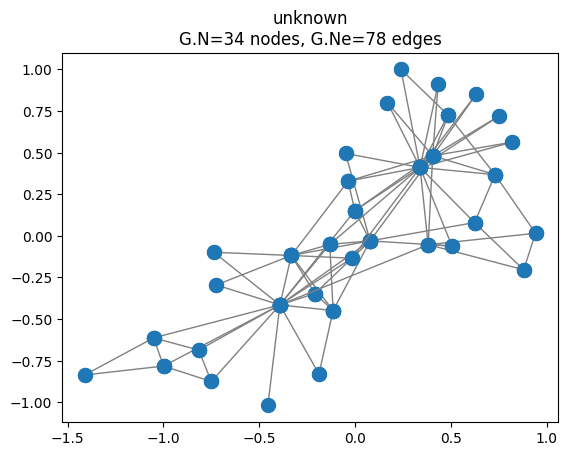

In [23]:
#plot graph
G.set_coordinates()
G.plot()


In [39]:
def subgraph_mapping(map_dict):
    subgraph_mapping = {}
    for i in map_dict[0].keys():
        new_map = map_dict[0][i]
        if len(map_dict) > 1:
            for j in range(1, len(map_dict)):
                new_map = map_dict[j][new_map]    
        subgraph_mapping[i] = new_map
    return subgraph_mapping

def metanode_to_node_mapping(map_dict, prev_keep):
    temp = dict()
    for node, metanode in map_dict.items():
        if metanode not in set(temp.keys()):
            temp[metanode] = [node]
        else:
            temp[metanode].append(node)
    return temp

def metanode_to_node_mapping_new(map_dict, orig_dict):
    temp = dict()
    for node, metanode in map_dict.items():
        if metanode not in set(temp.keys()):
            temp[metanode] = [orig_dict[node]]
        else:
            temp[metanode].append(orig_dict[node])
    return temp

def orig_to_new_map(idxs):
    new_idxs = {}
    num = 0
    for i in idxs:
        new_idxs[num] = i
        num += 1
    return new_idxs

def neighbour(G, node):
    edges_connected_to_k = torch.nonzero(G.edge_index[0] == node, as_tuple=False)
    neighbors_k = G.edge_index[1][edges_connected_to_k].flatten()
    return neighbors_k

def nodes_2_neighbours(G, nodes):
    if not hasattr(G, 'edge_index'):
        raise ValueError("The input graph must have the 'edge_index' attribute.")
    if not isinstance(nodes, torch.Tensor):
        nodes = torch.tensor(nodes)
    edge_index_gpu = G.edge_index
    mask = (edge_index_gpu[0] == nodes.unsqueeze(-1)).any(dim=0)
    edges_connected_to_nodes = edge_index_gpu[:, mask]
    neighbors = torch.unique(edges_connected_to_nodes[1])
    return neighbors

def neighbor_2_cluster(Nt_node,node_2_comp_node, comp_node_2_meta_node):
    connected_clusters = torch.tensor([], dtype=torch.long)
    for node in Nt_node:
        comp_node = node_2_comp_node[node]
        meta_node = comp_node_2_meta_node[comp_node]
        connected_clusters = torch.cat((connected_clusters, torch.tensor([meta_node])))
    connected_clusters = torch.unique(connected_clusters)
    return connected_clusters

def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [81]:
from tqdm import tqdm
cluster_node = True
extra_node = False
G = gsp.graphs.Graph(W=to_dense_adj(dataset[0].edge_index)[0])
H =  extract_components(G)
candidate = sorted(H, key=lambda x: len(x.info['orig_idx']), reverse=True)
number = 0
C_list=[]
Gc_list=[]
subgraph_list=[]
extra_node = True
for n in tqdm(range(len(candidate))):
    H = candidate[number]
    H_feature = dataset[0].x[H.info['orig_idx']]
    node_2_comp_node = orig_to_new_map(H.info['orig_idx'])
    if len(H.info['orig_idx']) > 1:
        C, Gc, Call, Gall, mapping_dict_list = coarsen(H, r=0.9, method="variation_neighborhood")
        if len(H.info['orig_idx']) > 10:
            C_list.append(C)
            Gc_list.append(Gc)
        comp_node_2_meta_node = subgraph_mapping(mapping_dict_list)
        meta_node_2_node = metanode_to_node_mapping_new(comp_node_2_meta_node, node_2_comp_node)
        for key, value in meta_node_2_node.items():
            value = torch.LongTensor(value)
            value, _ = torch.sort(value)
            actual_ext = torch.LongTensor([])
            num_nodes = len(value)
            if cluster_node:
                new_edges = torch.tensor([], dtype=torch.long)
                new_features = torch.tensor([], dtype=torch.float)
                meta_node_2_new_node = {}
                for node in value:
                    N_node = neighbour(dataset[0], node)
                    Nt_node = N_node[~torch.isin(N_node, value)]
                    connected_clusters = neighbor_2_cluster(Nt_node.tolist(), node_2_comp_node, comp_node_2_meta_node)
                    for cluster in connected_clusters:
                        if cluster not in meta_node_2_new_node:
                            meta_node_2_new_node[cluster] = torch.LongTensor([num_nodes])
                            actual_ext = torch.cat((actual_ext, torch.tensor([num_nodes])), dim=0)
                            num_nodes += 1
                        new_feature = torch.FloatTensor([C.dot(H_feature)[cluster]])
                        new_features = torch.cat((new_features, new_feature), dim=0)
                        e1 = torch.tensor([node, meta_node_2_new_node[cluster]])
                        e2 = torch.tensor([meta_node_2_new_node[cluster], node])
                        new_edges = torch.cat((new_edges, e1.unsqueeze(0)), dim=0)
                        new_edges = torch.cat((new_edges, e2.unsqueeze(0)), dim=0)
                    #we need to have get the cross cluster edges
                    
            elif extra_node:
                ext_nodes = nodes_2_neighbours(dataset[0], value)
                actual_ext = ext_nodes[~torch.isin(ext_nodes, value)]
                value = torch.cat((value, ext_nodes), dim=0)
                value = torch.unique(value)
            value, _ = torch.sort(value)
            M = dataset[0].subgraph(value)
            if cluster_node:
                M.x = torch.cat((M.x, new_features), dim=0)
                M.edge_index = torch.cat((M.edge_index.T, new_edges), dim=0).T
                M.y = torch.cat((M.y, torch.zeros(len(new_features))))
            M.actual_ext = actual_ext
            subgraph_list.append(M)
    else:
        comp_node_2_meta_node = subgraph_mapping([{0: 0}])
        meta_node_2_node = metanode_to_node_mapping_new(comp_node_2_meta_node, node_2_comp_node)
        for key, value in meta_node_2_node.items():
            value = torch.LongTensor(value)
            value, _ = torch.sort(value)
            actual_ext = torch.LongTensor([])
            num_nodes = len(value)
            if cluster_node:
                new_edges = torch.tensor([], dtype=torch.long)
                new_features = torch.tensor([], dtype=torch.float)
                meta_node_2_new_node = {}
                for node in value:
                    N_node = neighbour(dataset[0], node)
                    Nt_node = N_node[~torch.isin(N_node, value)]
                    connected_clusters = neighbor_2_cluster(Nt_node.tolist(), node_2_comp_node, comp_node_2_meta_node)
                    for cluster in connected_clusters:
                        if cluster not in meta_node_2_new_node:
                            meta_node_2_new_node[cluster] = torch.LongTensor([num_nodes])
                            actual_ext = torch.cat((actual_ext, torch.tensor([num_nodes])), dim=0)
                            num_nodes += 1
                        new_feature = torch.FloatTensor([C.dot(H_feature)[cluster]])
                        new_features = torch.cat((new_features, new_feature), dim=0)
                        e1 = torch.tensor([node, meta_node_2_new_node[cluster]])
                        e2 = torch.tensor([meta_node_2_new_node[cluster], node])
                        new_edges = torch.cat((new_edges, e1.unsqueeze(0)), dim=0)
                        new_edges = torch.cat((new_edges, e2.unsqueeze(0)), dim=0)
                    #we need to have get the cross cluster edges

            if extra_node:
                ext_nodes = nodes_2_neighbours(graph_data, value)
                actual_ext = ext_nodes[~torch.isin(ext_nodes, value)]
                value = torch.cat((value, ext_nodes), dim=0)
                value = torch.unique(value)
            value, _ = torch.sort(value)
            M = graph_data.subgraph(value)
            if cluster_node:
                M.x = torch.cat((M.x, new_features), dim=0)
                M.edge_index = torch.cat((M.edge_index.T, new_edges), dim=0).T
                M.y = torch.cat((M.y, torch.zeros(len(new_features))))
            M.actual_ext = actual_ext
            subgraph_list.append(M)
        number += 1

100%|██████████| 1/1 [00:00<00:00, 17.51it/s]

In [82]:
subgraph_list

[Data(x=[13, 34], edge_index=[2, 36], y=[13], train_mask=[5], actual_ext=[8]),
 Data(x=[14, 34], edge_index=[2, 18], y=[14], train_mask=[6], actual_ext=[8]),
 Data(x=[7, 34], edge_index=[2, 14], y=[7], train_mask=[3], actual_ext=[4]),
 Data(x=[30, 34], edge_index=[2, 88], y=[30], train_mask=[18], actual_ext=[12]),
 Data(x=[4, 34], edge_index=[2, 6], y=[4], train_mask=[2], actual_ext=[2])]

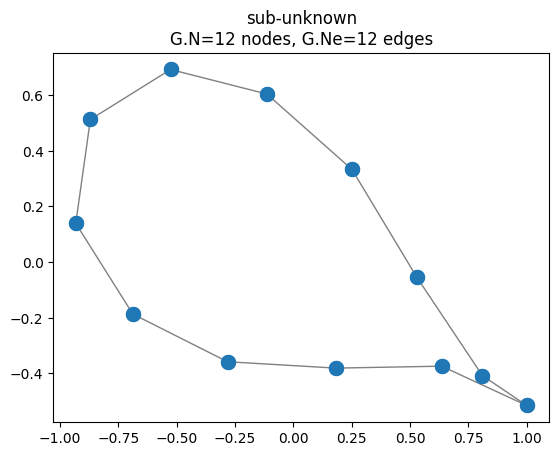

In [38]:
#plot the 1st component of graph
candidate[0].set_coordinates()
candidate[0].plot()

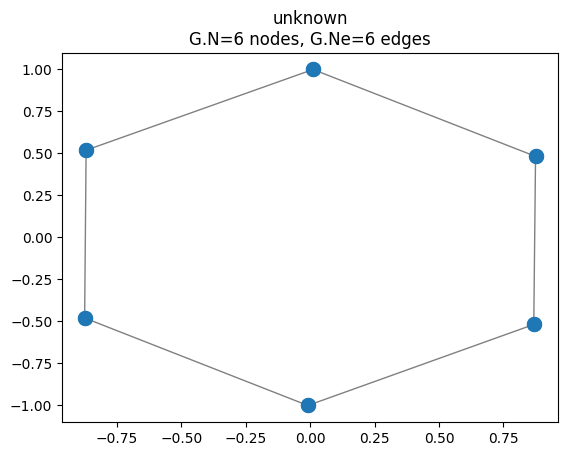

In [39]:
#plot the coarsened graph of 1st component
Gc_list[0].set_coordinates()
Gc_list[0].plot()

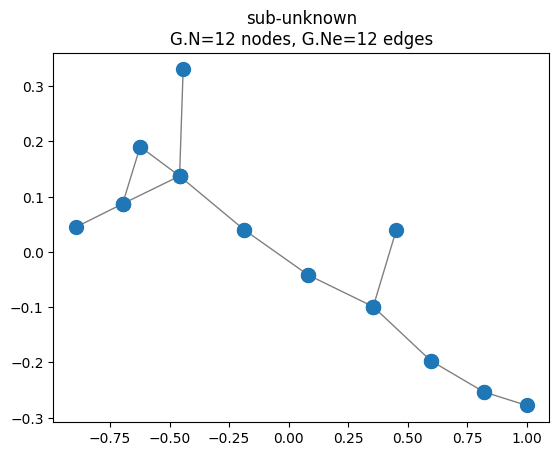

In [40]:
candidate[1].set_coordinates()
candidate[1].plot()

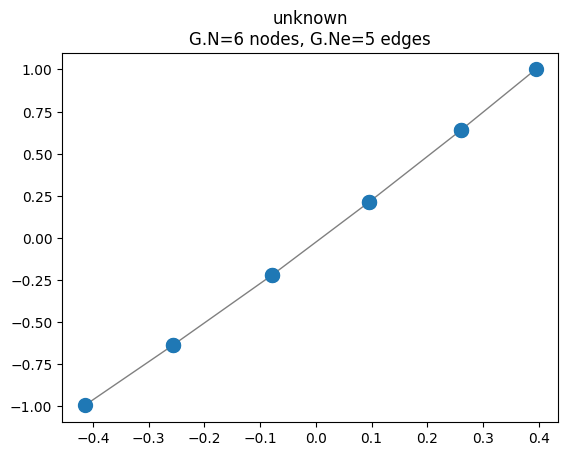

In [41]:
Gc_list[1].set_coordinates()
Gc_list[1].plot()